<a href="https://colab.research.google.com/github/comandi1969/AIFFEL_Online_Quest/blob/main/Exploration06/Stable_Diffusion_ControlNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Stable Diffusion 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

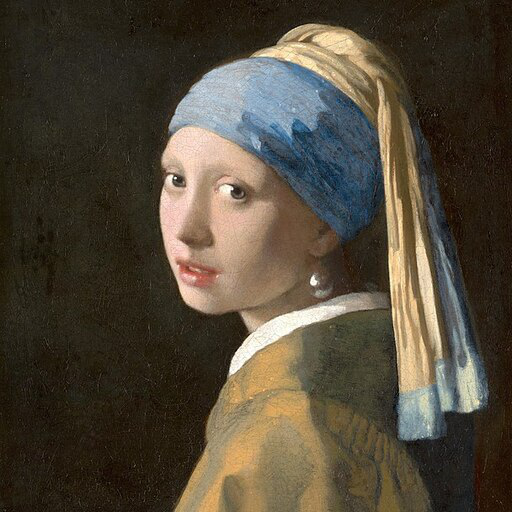

In [3]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

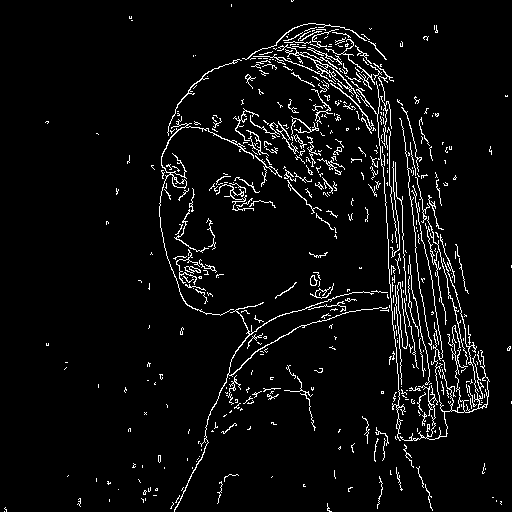

In [4]:
import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

In [5]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

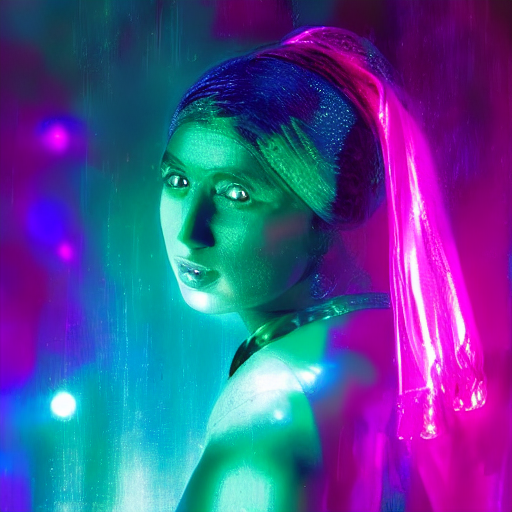

In [6]:
from diffusers import UniPCMultistepScheduler
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다.
generator = torch.manual_seed(0)

# 이미지를 생성합니다.
canny_image1 = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]
# 생성된 이미지를 저장합니다.
canny_image1.save("/content/drive/MyDrive/Stablediffusion/canny_image1.png")

# 생성된 이미지를 출력합니다.
canny_image1

  0%|          | 0/20 [00:00<?, ?it/s]

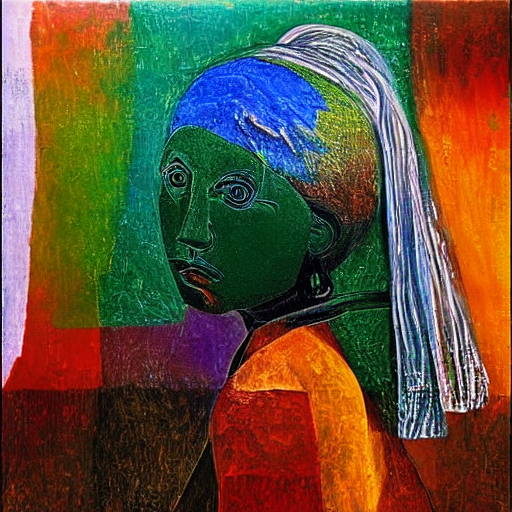

In [7]:
# Q. 프롬프트를 작성하고 하이퍼파라미터를 조절하여 이미지를 생성해 보세요.

# 새로운 이미지를 생성합니다.
canny_image2 = canny_pipe(
    prompt="in the style of Pablo Picasso oil paintings",
    num_inference_steps=20,
    generator=generator,
    image=canny_image  # 윤곽선 검출된 이미지를 기반으로 합니다.
).images[0]

# 생성된 이미지를 저장합니다.
canny_image2.save("/content/drive/MyDrive/Stablediffusion/canny_image2.png")

# 생성된 이미지를 출력합니다.
canny_image2

In [8]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00


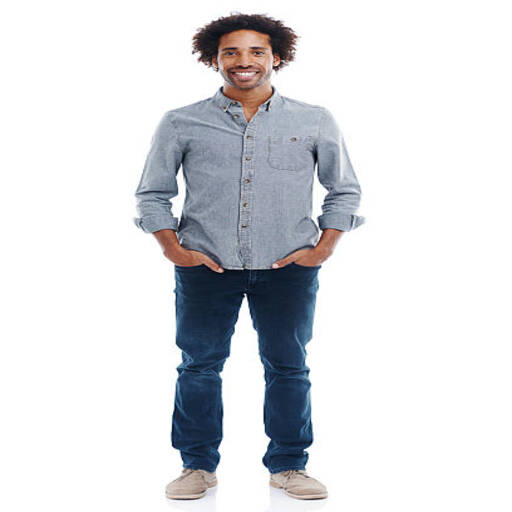

In [9]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

cuda


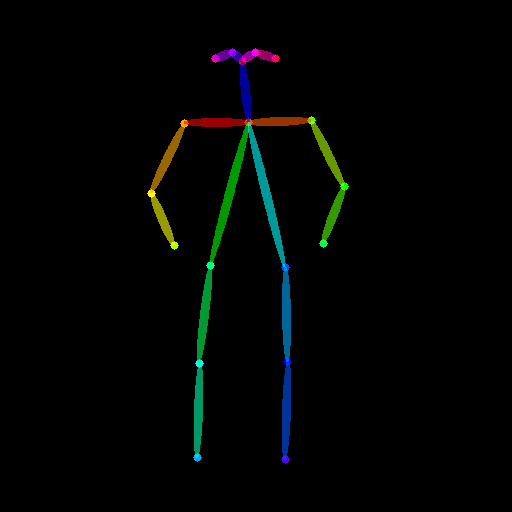

In [10]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [11]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

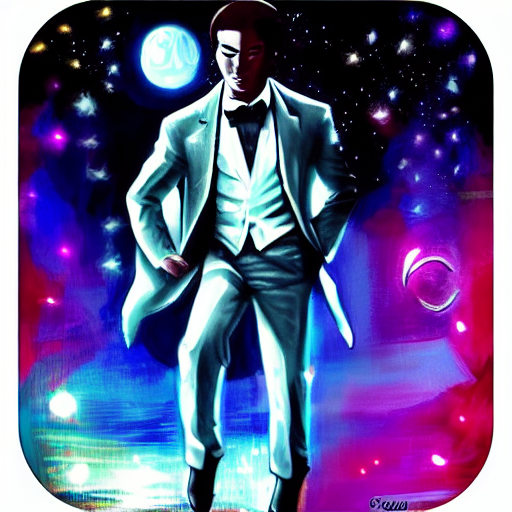

In [12]:
from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
# 1. 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
generator = torch.manual_seed(0)

# 2. 이미지 생성을 위한 프롬프트와 부정적 프롬프트를 정의합니다.
prompt = "dancing in the moonlight"
negative_prompt = "no animals"

images = openpose_image

# 3. 이미지를 생성하는 파이프라인을 사용하여 이미지를 생성합니다.
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
    image=images
).images[0]

# 생성된 이미지를 출력합니다.
openpose_image1

  0%|          | 0/30 [00:00<?, ?it/s]

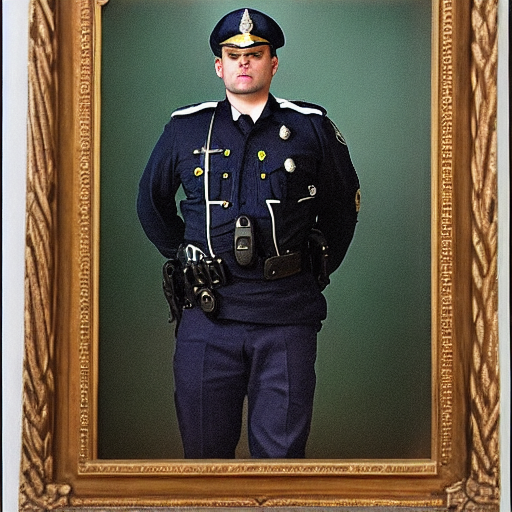

In [13]:
# 새로운 프롬프트와 부정적 프롬프트를 정의합니다.
new_prompt = "a police officer"
new_negative_prompt = "no vehicles"

# 이미지 생성을 위한 하이퍼파라미터를 조절합니다.
new_num_inference_steps = 30

# 새로운 이미지를 생성합니다.
openpose_image2 = openpose_pipe(
    prompt=new_prompt,
    negative_prompt=new_negative_prompt,
    num_inference_steps=new_num_inference_steps,
    generator=generator,
    image=images
).images[0]

# 생성된 이미지를 출력합니다.
openpose_image2

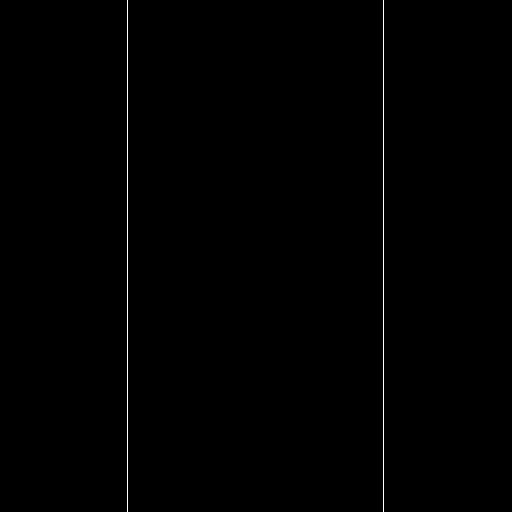

In [14]:
from diffusers.utils import load_image
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# 이미지를 불러오세요.
canny_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")

# threshhold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다.
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다.
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다.
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image


cuda


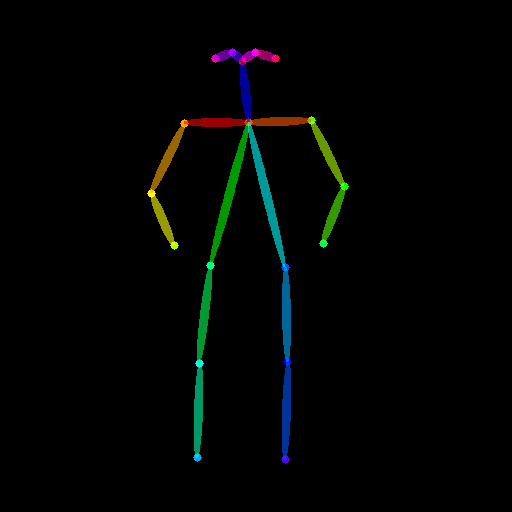

In [15]:
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다.
openpose_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")

# OpenposeDetector를 사용하여 인체 자세를 검출합니다.
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

openpose_image


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

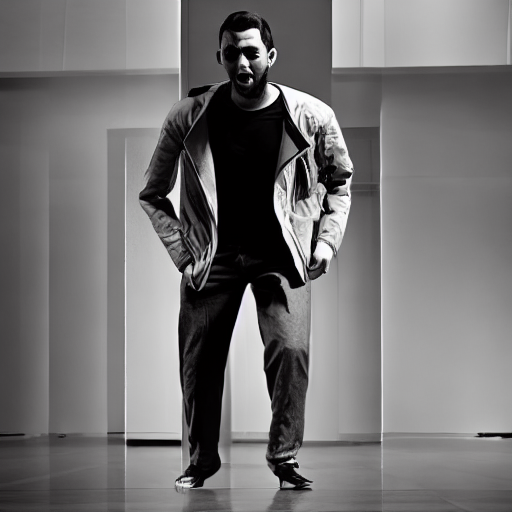

In [16]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
torch.cuda.empty_cache()
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다.
# 아래 코드는 오류 발생 이유는 모름
# canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
# openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
# controlnets = [canny_controlnet, openpose_controlnet]

controlnets = [ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16), ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)]

# 리스트 controlnets를 파이프라인으로 전달합니다.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다.
prompt = "a person dancing in a modern art setting"
negative_prompt = "no animals"

# seed를 지정
generator = torch.Generator(device = "cuda").manual_seed(2023)

images = [openpose_image, canny_image]

# 이미지를 생성
canny_openpose_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=20,
    generator=generator,
    image=images
    ).images[0]

# 생성된 이미지를 저장합니다.
canny_openpose_image.save("/content/drive/MyDrive/Stablediffusion/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.
canny_openpose_image

# 회고
처음 배운 Stable Diffusion 모델은 아주 흥미롭고 재미있는 분야라는 생각이듭니다.텍스트를 입력하면 그림을 출력할 수 있다는 게 무척이나 이상적으로 아이들 상상력을 키우거나 기억을 되살리거나 하는 일에 적용하면 좋은 듯 합니다.
뭐 범인의 몽타쥬를 그리는 등...

다만 모델을 구현하기가 많이 어렵다는 것을 알았습니다. 하지만 재미있는 경험이고 그만큼 보람도 있었습니다.

특히 아래 Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만드는 과정에서 많은 시행 착오를 해 더욱 기억에 남습니다. ^^


controlnets = [ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16), ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)]
